# NLP and Finance

**Question:** Can r/wallstreetbets Predict Stock Movements?

Final Project for CS 406 NLP and the Web

In [1]:
import os
import html
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding, 
    EarlyStoppingCallback, 
    TrainingArguments, 
    Trainer
)

In [2]:
# Configuration and Utilities

# Settings for better visualization
pd.set_option("display.max_colwidth", 256)

# Constants for label consistency
id2label = {0: "positive", 1: "negative", 2: "neutral"}
label2id = {"positive": 0, "negative": 1, "neutral": 2}
label_map_finbert = {0: 2, 1: 0, 2: 1}

# Cleaning social media text
def clean_social_media_text(series):
    cleaned = series.copy()
    cleaned = cleaned.str.replace(r"(https?://\S+|www\.\S+)", "", regex=True)
    cleaned = cleaned.fillna("").apply(html.unescape)
    cleaned = cleaned.str.replace(r"\s+", " ", regex=True).str.strip()
    return cleaned

# A. DOMAIN ADAPTION FOR SENTIMENT ANALYSIS

In [3]:
# Model selection for comparison
models = [
    ("ProsusAI/finbert", "direct"),
    ("ProsusAI/finbert", "adapt"),
    ("google-bert/bert-base-uncased", "adapt"),
    ("microsoft/deberta-v3-base", "adapt"),
]

### 1.1 Load r/wallstreetbets Data to Learn Domain Slang

In [4]:
# Load labeled r/wallstreetbets datasets (Source: https://arxiv.org/html/2505.07871v1)
path = "https://github.com/moonscape95/WSBS/raw/refs/heads/main/data/"

df_full = pd.read_csv(f"{path}/WSB_full.csv", low_memory=False).rename(columns=str.lower)
df_all_agree = pd.read_csv(f"{path}/WSB_all_agree.csv", low_memory=False).rename(columns=str.lower)

# Align labels with FinBERT's internal schema
df_full["label"] = df_full["label"].map(label_map_finbert)
df_all_agree["label"]   = df_all_agree["label"].map(label_map_finbert)

In [5]:
# Quick verification of label distribution
datasets = {"WSB_full": df_full, "WSB_all_agree": df_all_agree}
pd.DataFrame({
    name: [
        (df["label"].value_counts(normalize=True) * 100).round(1).get(0, 0),
        (df["label"].value_counts(normalize=True) * 100).round(1).get(1, 0),
        (df["label"].value_counts(normalize=True) * 100).round(1).get(2, 0),
        len(df),
    ]
    for name, df in datasets.items()
}, index=["Positive (%)", "Negative (%)", "Neutral (%)", "Total (n)"]).T

,Positive (%),Negative (%),Neutral (%),Total (n)
WSB_full,38.8,29.3,31.8,2920.0
WSB_all_agree,43.2,33.0,23.8,1509.0


### 1.2 Dataset Partitioning (Gold)

In [6]:
# 1. Extract Test set (Goldstandard) from 'all_agree'
df_train_all_agree, df_test = train_test_split(
    df_all_agree, 
    test_size=0.20 * len(df_full) / len(df_all_agree), # from 'all_agree' set
    random_state=42, 
    stratify=df_all_agree['label']
    )

# 2. Extract Validation set (Goldstandard) from the remaining 'all_agree'
_, df_val = train_test_split(
    df_train_all_agree, 
    test_size=0.20 * len(df_full) / len(df_train_all_agree), # now from the train set above
    random_state=42, 
    stratify=df_train_all_agree['label']
    )

# 3. Create Training set by excluding test/val samples from the full dataset
df_train = df_full[~df_full['text'].isin(pd.concat([df_test['text'], df_val['text']]))].copy()

print(f"\nFinal Split Results:")
print(f"-> Train: {len(df_train)} samples")
print(f"-> Val:    {len(df_val)} samples (Gold)")
print(f"-> Test:   {len(df_test)} samples (Gold)")


Final Split Results:
-> Train: 1747 samples
-> Val:    584 samples (Gold)
-> Test:   584 samples (Gold)


In [7]:
# Clean text data
df_train["text"] = clean_social_media_text(df_train["text"])
df_val["text"] = clean_social_media_text(df_val["text"])
df_test["text"] = clean_social_media_text(df_test["text"])

# Convert to Hugging Face Dataset format for the Trainer API
train_set = Dataset.from_pandas(df_train[['text', 'label']])
val_set = Dataset.from_pandas(df_val[['text', 'label']])
test_set = Dataset.from_pandas(df_test[['text', 'label']])

### 1.3 Training (Domain Adaption)

In this block, we perform fine-tuning of the models to prepare them for the specific r/wallstreetbets slang.

In [8]:
# Training (Domain Adaption)

train_metrics = {}

for model_id, mode in models:
    if mode != "adapt":
        continue
    
    # Define paths for saving artifacts
    output_dir = f"./results_{model_id.split('/')[-1]}"

    # Skip processing if model is already trained and saved
    if os.path.isfile(f"{output_dir}/config.json") and any(os.path.isfile(f"{output_dir}/{w}") for w in ("model.safetensors","pytorch_model.bin")):
        print(f"Model {model_id} already trained. Skipping...")
        continue
    
    # Tokenization Setup
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=256)

    train_set_tokenized = train_set.map(tokenize_function, batched=True)
    val_set_tokenized = val_set.map(tokenize_function, batched=True)

    # Metrics Initialization
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average="weighted")
        }

    # Model Initialization
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, 
        num_labels=3, 
        id2label=id2label, 
        label2id=label2id,
    )

    # Training Configuration
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=12,
        weight_decay=0.01,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_set_tokenized,
        eval_dataset=val_set_tokenized,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    # Execution
    trainer.train()
    trainer.save_model(output_dir)        
    tokenizer.save_pretrained(output_dir)

    train_metrics[model_id] = trainer.evaluate()

# Display cross-model results
pd.DataFrame(train_metrics).T

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.700565,0.705479,0.698169
2,No log,0.658983,0.717466,0.710682
3,No log,0.718594,0.736301,0.737294
4,No log,0.931944,0.708904,0.704536
5,0.534000,1.148306,0.703767,0.702549


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.930663,0.542808,0.454230
2,No log,0.788830,0.667808,0.666856
3,No log,0.742047,0.695205,0.693135
4,No log,0.790010,0.703767,0.706443
5,0.683500,1.025153,0.655822,0.661988
6,0.683500,1.154626,0.720890,0.722142
7,0.683500,1.304276,0.708904,0.711232
8,0.683500,1.392487,0.705479,0.704627


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.957684,0.563356,0.449748
2,No log,0.644975,0.760274,0.761232
3,No log,0.603961,0.761986,0.761443
4,No log,0.684698,0.761986,0.755935
5,0.688200,0.668221,0.782534,0.781044
6,0.688200,0.855169,0.768836,0.766578
7,0.688200,1.084987,0.753425,0.749903


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
ProsusAI/finbert,0.718594,0.736301,0.737294,0.9586,609.206,38.597,5.0
google-bert/bert-base-uncased,1.154626,0.720890,0.722142,0.9590,608.944,38.580,8.0
microsoft/deberta-v3-base,0.668221,0.782534,0.781044,1.9867,293.955,18.624,7.0


### 1.4 Test the Domain Adaption (Unseen Data)

Here we check the performance on the previously separated "Goldstandard" test data.

In [9]:
# Test the Domain Adaption (Unseen Data)

evaluation_metrics = {}

for model_id, mode in models:
    short = model_id.split("/")[-1]
    label = f"{short} ({'base' if mode == 'direct' else 'adapt'})"
    model_path = model_id if mode == "direct" else f"./results_{short}"

    # Load resources
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=256)
    
    test_set_tokenized = test_set.map(tokenize_function, batched=True)

    # Load model for prediction
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=3,
        id2label=id2label,
        label2id=label2id,
    )

    # Inference setup
    evaluation_args = TrainingArguments(
        output_dir="./tmp_eval",
        per_device_eval_batch_size=16,
        dataloader_drop_last=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=evaluation_args,
        data_collator=data_collator,
    )

    # Store predictions for analysis
    evaluation_metrics[label] = trainer.predict(test_set_tokenized)

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

The tokenizer you are loading from './results_deberta-v3-base' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/584 [00:00<?, ? examples/s]

### 1.5 Test Analysis (Quantitative and Qualitative)

Conclusion of the sentiment phase: How good are the models really? We look at metrics such as the F_1 score and analyze misclassifications.

In [10]:
# Quantitative Test Analysis

tables = {}

# Generate Classification Reports
for name, output in evaluation_metrics.items():
    report = classification_report(
        y_true=output.label_ids, 
        y_pred=np.argmax(output.predictions, axis=1),
        target_names=[id2label[i] for i in range(3)],
        output_dict=True,
        zero_division=0,
        )
    
    tables[name] = pd.DataFrame(report).T.loc[
        [id2label[i] for i in range(3)], 
        ["precision", "recall", "f1-score"]
        ]
    
pd.concat(tables).round(2)

precision  recall  f1-score
finbert (base)            positive       0.89    0.15      0.26
                          negative       0.71    0.40      0.51
                          neutral        0.30    0.92      0.45
finbert (adapt)           positive       0.78    0.81      0.80
                          negative       0.71    0.67      0.69
                          neutral        0.63    0.62      0.62
bert-base-uncased (adapt) positive       0.79    0.73      0.76
                          negative       0.66    0.73      0.69
                          neutral        0.63    0.63      0.63
deberta-v3-base (adapt)   positive       0.85    0.81      0.83
                          negative       0.71    0.81      0.76
                          neutral        0.70    0.62      0.66

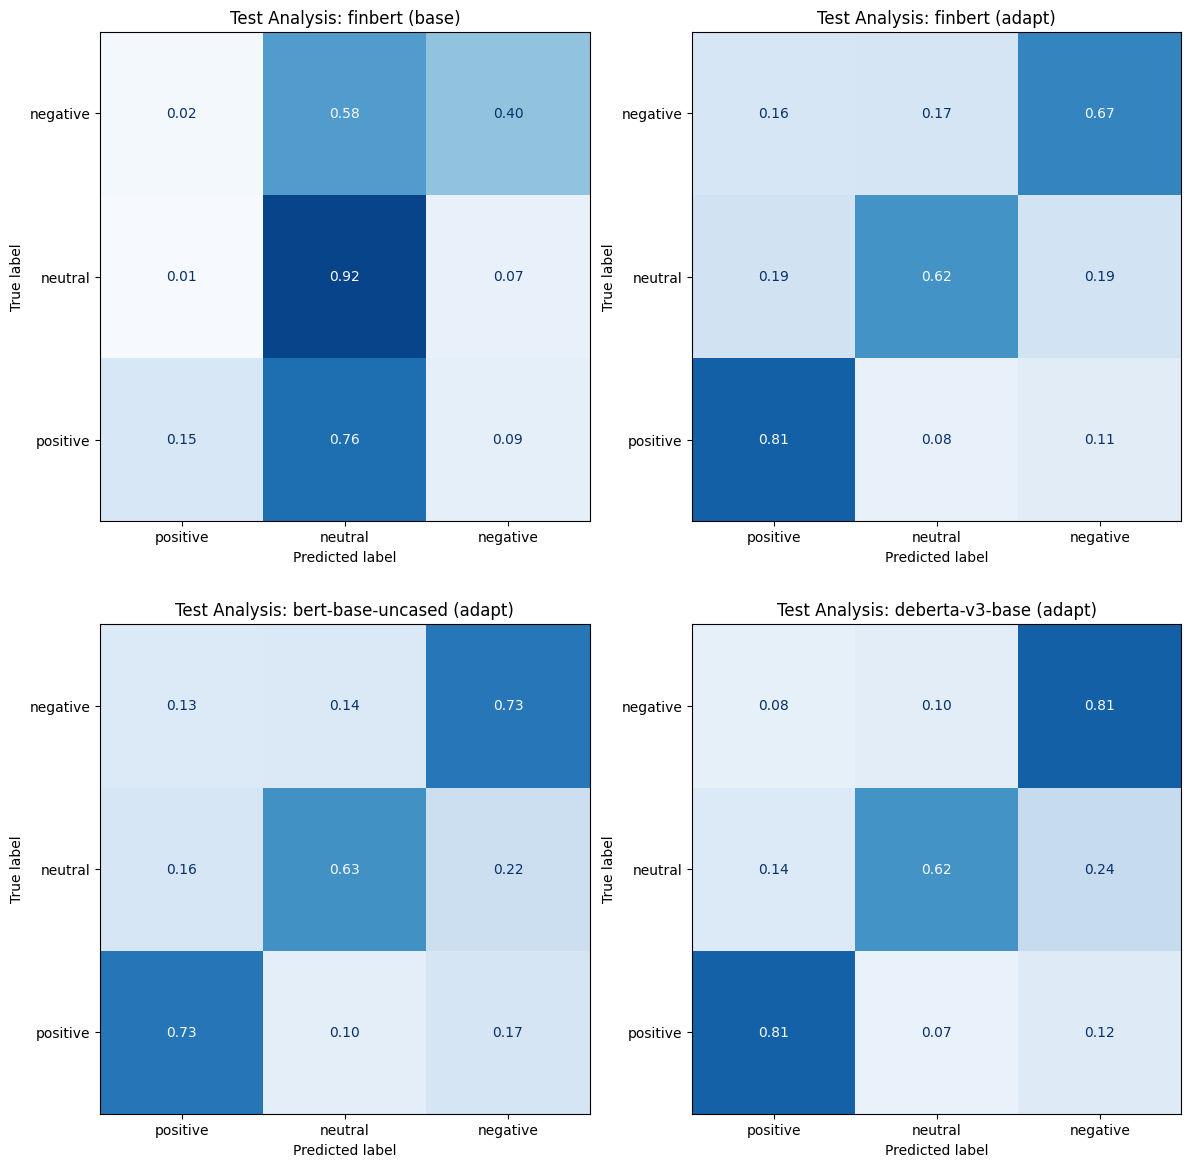

In [11]:
# Visualization Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
order = [0, 2, 1]

for i, (name, output) in enumerate(evaluation_metrics.items()):
    ax = axes[i]
    
    y_pred = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids
    
    cm = confusion_matrix(
        y_true, 
        y_pred, 
        labels=order, 
        normalize="true"
        )
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in order])
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format=".2f", im_kw={"vmin": 0, "vmax": 1})    
    ax.set_title(f"Test Analysis: {name}")
    ax.grid(False)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [12]:
# Qualitative Analysis: Error Drill Down

model_label = "finbert (base)"

probs = np.exp(evaluation_metrics[model_label].predictions)
probs /= probs.sum(1, keepdims=True)
df = pd.DataFrame({
    "text": df_test.text,
    "true": evaluation_metrics[model_label].label_ids,
    "pred": probs.argmax(1),
    "conf": probs.max(1),
})

# Identifies samples where the model was confidently wrong
df.query(
    "text in @df_all_agree.text and true != pred"
    ).nlargest(5, "conf").assign(
        true=lambda x: x.true.map(id2label), 
        pred=lambda x: x.pred.map(id2label)
        )


,text,true,pred,conf
1174,EV maker Lordstown Down 60% from high with 77% short interest ripe for a short sqeeze pump,positive,negative,0.969016
59,Some simple math for y'all... SPY is down about 19% from its high. In the prior 20 years or so the market has had much larger declines. After the dotcom bust it declined about 42% and during the Housing bust it declined about 48%. A measly 19% drop off...,neutral,negative,0.959092
30,"Looking at SPCE and CLOV price action, I think OPEN could be a multi-bagger next several weeks leading up to earnings. \~Doubled down on riding shares. No DD. Just a feeling.",positive,negative,0.955728
786,Get it on this dip. Dont get left behind! you'll be kickin yourselves. Gonna break $15 today! Has an earnings beat and gets downgraded!!!!! WHAT!? just another example of the street trying to kill THE REVOLUTION!!!!!,positive,negative,0.949151
1098,"Retirement savings $214,000.00 on 14,000 shares of Lithium America! s con do DD and see just where this is going to go!",positive,neutral,0.937301


# B. BACKTESTING ON (RECORDED) "LIVE" DATA

### 2.1 Load r/wallstreetbets Data with Creation Date for Backtesting

In [13]:
# Download historical r/wallstreetbets posts from 03/2022 - 03/2025 for backtesting
path = kagglehub.dataset_download("gpreda/wallstreetbets-2022")
df_raw = pd.read_csv(f"{path}/wallstreetbets_2022.csv", low_memory=False).rename(columns=str.lower)

# Ensure data types for core metrics and dates
df_raw["score"] = pd.to_numeric(df_raw["score"], errors="coerce").fillna(0).astype(int)
df_raw["comms_num"] = pd.to_numeric(df_raw["comms_num"], errors="coerce").fillna(0).astype(int)
df_raw["date"] = pd.to_datetime(df_raw["created"], unit="s", errors="coerce").dt.date

Using Colab cache for faster access to the 'wallstreetbets-2022' dataset.


### 2.2 Filter on $TICKER == 'NVDA' and Build Dataset

In [14]:
# Define regex for NVDA/NVIDIA mentions (case-insensitive)
ticker = r'(?i)\b\$?NVDA|\bNVIDIA'
mask = df_raw["title"].fillna("").str.contains(ticker, regex=True) | \
       df_raw["body"].fillna("").str.contains(ticker, regex=True)

df_live = df_raw.loc[mask].copy()

In [15]:
# Consolidate title and body into a single 'text' field
# Comments usually only have a body; posts are combined for full context
is_comment = df_live["title"].str.contains("Comment", na=False)
df_live["text"] = df_live["body"].fillna("")
df_live.loc[~is_comment, "text"] = (
    df_live.loc[~is_comment, "title"].fillna("").str.strip() + 
    " " + 
    df_live.loc[~is_comment, "body"].fillna("")
    )

In [16]:
# Apply Text Cleaning
df_live["text"] = clean_social_media_text(df_live["text"])

# Convert to Hugging Face Dataset format for the Inference API
live_set = Dataset.from_pandas(df_live[["text"]])

In [17]:
# Display filtered data preview
df_live[["text", "created", "score", "comms_num"]]

,text,created,score,comms_num
237,"🕵️‍♂️ I SPY in My TSLA TA - Wednesday March 30, 2022 - Scalpers Delight [🕵️‍♂️ I SPY, GME, TSLA, AMD, and NVDA - 3/28 Scalpers Delight]( # Economic Calendar - March 30, 2022 # SPY - March 30 - Technical Analysis * Bullish 🎯: 466.83 - 471.53 (needs to b...",1.648597e+09,27,14
565,I’m chanting on nvda to tank for my puts even though I own it in another retirement savings account . Would mind at all seeing it dip to $230,1.649238e+09,1,0
737,maybe my Nvda $242.5 put prints afterall,1.649237e+09,3,0
1048,NVDA -$4 and it’s another 5 hours till open ☠️,1.649235e+09,5,0
1208,>FANG+ Constituents: \>$AAPL 173.72 -0.8% $AMZN 3262.52 -0.7% $BABA 109.47 -1.42% $BIDU 143.26 -1.42% $FB 228.87 -1.29% $GOOG 2798.97 -0.82% $NFLX 376.5 -0.78% $NVDA 255.71 -1.37% $TSLA 1074.15 -1.53% $MSFT 308.15 -0.9% \>$TWTR 49.73 -2.51% ^IGSquawk ^...,1.649234e+09,3,0
...,...,...,...,...
1098829,Guys..I am not having a good feeling about AI trade at all. Im gonna learn to trade something totally different from NVDA and SMCI. Looks cooked long term,1.743107e+09,2,0
1099021,Investors just stupid “bad guidance” when numbers are great. Same happened with nvidia. It’s like they want them to promise them quadruple in sales and revenue next quarter,1.743107e+09,1,0
1099110,Fkkk idk man I’m giving up on Nvidia even tho it’s my boy ![img](emote|t5_2th52|4260),1.743107e+09,1,0
1099131,"Everything moves in the opposite direction. LULU beat earnings? better go down. Less sales for TSLA? better pump it up. NVDA Jensen shows up with the greatest new chips and be like hey guys check these out, the market goes oh wow they're so great, so v...",1.743107e+09,5,0


### 2.3 Determine "Live" Sentiments

In [18]:
# Determine "Live" sentiments

live_sentiment = {}

for model_id, mode in models:
    short = model_id.split("/")[-1]
    model_label = f"{short} ({'base' if mode == 'direct' else 'adapt'})"
    model_path = model_id if mode == "direct" else f"./results_{short}"
    
    results_dir = f"./live_sentiment_results"
    os.makedirs(results_dir, exist_ok=True)
    results_path = f"{results_dir}/{model_label}.csv"

    # Check for cached results to save compute time
    if os.path.exists(results_path):
        live_sentiment[model_label] = pd.read_csv(results_path, index_col=0).set_axis(df_live.index, axis=0)
        print(f"Sentiment data loaded from cache: {results_path}")
        continue

    # Load resources
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=256)
    
    live_set_tokenized = live_set.map(tokenize_function, batched=True)

    # Load model for prediction
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path
        )

    # Inference setup
    args = TrainingArguments(
        output_dir="./tmp_pred", 
        per_device_eval_batch_size=16, 
        report_to="none"
        )

    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=data_collator
        )
    
    pred = trainer.predict(live_set_tokenized)

    # Convert logits to probabilities via Softmax
    logits = pred.predictions
    probs = np.exp(logits - logits.max(1, keepdims=True))
    probs /= probs.sum(1, keepdims=True)

    # Store and cache results
    df_probs = pd.DataFrame(probs, columns=[id2label[i] for i in range(probs.shape[1])])
    df_probs.index = df_live.index

    df_probs.to_csv(results_path, index=True)
    print(f"Sentiment data saved: {results_path}")

    live_sentiment[model_label] = df_probs

Map:   0%|          | 0/18891 [00:00<?, ? examples/s]

Sentiment data saved: ./live_sentiment_results/finbert (base).csv


Map:   0%|          | 0/18891 [00:00<?, ? examples/s]

Sentiment data saved: ./live_sentiment_results/finbert (adapt).csv


Map:   0%|          | 0/18891 [00:00<?, ? examples/s]

Sentiment data saved: ./live_sentiment_results/bert-base-uncased (adapt).csv


The tokenizer you are loading from './results_deberta-v3-base' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/18891 [00:00<?, ? examples/s]

Sentiment data saved: ./live_sentiment_results/deberta-v3-base (adapt).csv


In [19]:
# Example Sentiments determined by 'FinBERT (base)'
df_live[["text"]].join(live_sentiment["finbert (base)"])

,text,positive,negative,neutral
237,"🕵️‍♂️ I SPY in My TSLA TA - Wednesday March 30, 2022 - Scalpers Delight [🕵️‍♂️ I SPY, GME, TSLA, AMD, and NVDA - 3/28 Scalpers Delight]( # Economic Calendar - March 30, 2022 # SPY - March 30 - Technical Analysis * Bullish 🎯: 466.83 - 471.53 (needs to b...",0.070744,0.041792,0.887464
565,I’m chanting on nvda to tank for my puts even though I own it in another retirement savings account . Would mind at all seeing it dip to $230,0.039194,0.557148,0.403657
737,maybe my Nvda $242.5 put prints afterall,0.056760,0.027181,0.916059
1048,NVDA -$4 and it’s another 5 hours till open ☠️,0.044866,0.024911,0.930223
1208,>FANG+ Constituents: \>$AAPL 173.72 -0.8% $AMZN 3262.52 -0.7% $BABA 109.47 -1.42% $BIDU 143.26 -1.42% $FB 228.87 -1.29% $GOOG 2798.97 -0.82% $NFLX 376.5 -0.78% $NVDA 255.71 -1.37% $TSLA 1074.15 -1.53% $MSFT 308.15 -0.9% \>$TWTR 49.73 -2.51% ^IGSquawk ^...,0.043186,0.042871,0.913943
...,...,...,...,...
1098829,Guys..I am not having a good feeling about AI trade at all. Im gonna learn to trade something totally different from NVDA and SMCI. Looks cooked long term,0.136329,0.015820,0.847852
1099021,Investors just stupid “bad guidance” when numbers are great. Same happened with nvidia. It’s like they want them to promise them quadruple in sales and revenue next quarter,0.213571,0.339893,0.446536
1099110,Fkkk idk man I’m giving up on Nvidia even tho it’s my boy ![img](emote|t5_2th52|4260),0.033913,0.158775,0.807312
1099131,"Everything moves in the opposite direction. LULU beat earnings? better go down. Less sales for TSLA? better pump it up. NVDA Jensen shows up with the greatest new chips and be like hey guys check these out, the market goes oh wow they're so great, so v...",0.060755,0.571946,0.367298


In [20]:
# Show final distribution comparison
pd.DataFrame({
    model_label: [
        (df.idxmax(axis=1).value_counts(normalize=True) * 100).round(1).get("positive", 0),
        (df.idxmax(axis=1).value_counts(normalize=True) * 100).round(1).get("negative", 0),
        (df.idxmax(axis=1).value_counts(normalize=True) * 100).round(1).get("neutral", 0),
        len(df),
    ]
    for model_label, df in live_sentiment.items()
}, index=["Positive (%)", "Negative (%)", "Neutral (%)", "Total (n)"]).T

,Positive (%),Negative (%),Neutral (%),Total (n)
finbert (base),7.6,13.8,78.6,18891.0
finbert (adapt),40.8,25.1,34.1,18891.0
bert-base-uncased (adapt),31.8,31.1,37.1,18891.0
deberta-v3-base (adapt),29.9,39.0,31.1,18891.0


### 2.4 Sentiment Aggregation

In [21]:
# Sentiment Aggregation

# Filter (posts only)
mask_posts = ~df_live["title"].str.contains("Comment", na=False)

daily_per_model = {}

for model_id, mode in models:
    short = model_id.split("/")[-1]
    model_label = f"{short} ({'base' if mode == 'direct' else 'adapt'})"
    
    # Basic data
    df_data = df_live.loc[mask_posts].copy()
    df_data["date"] = pd.to_datetime(df_data["date"]).dt.date
    df_sent = live_sentiment[model_label].loc[mask_posts].copy()

    # Weighting and Sentiment
    df_data["weight"] = np.log1p(df_data["score"]) + np.log1p(df_data["comms_num"])
    df_data["weight_sq"] = df_data["weight"] ** 2

    df_data["w_pos"] = df_sent["positive"] * df_data["weight"]
    df_data["w_neg"] = df_sent["negative"] * df_data["weight"]

    # Aggregation
    daily = df_data.groupby("date")[["weight", "weight_sq", "w_pos", "w_neg"]].sum()
    daily = daily[daily["weight"] > 0].copy()

    # Daily Sentiment calculation
    daily["net_sentiment"] = (daily["w_pos"] - daily["w_neg"]) / daily["weight"]
    n_eff = (daily["weight"] ** 2) / daily["weight_sq"]
    daily["sentiment"] = daily["net_sentiment"] * np.log1p(n_eff)

    daily_per_model[model_label] = daily

daily.head() # Show example of last processed model

,weight,weight_sq,w_pos,w_neg,net_sentiment,sentiment
date,,,,,,
2022-03-29,6.040255,36.484677,2.325249,2.412569,-0.014456,-0.010020
2022-04-01,2.397895,5.749902,0.087965,1.902947,-0.756906,-0.524647
2022-04-02,9.860058,97.220744,0.585669,8.918642,-0.845124,-0.585795
2022-04-04,15.029963,78.784515,5.865946,4.115062,0.116493,0.157564
2022-04-06,2.708050,7.333536,0.025168,2.483346,-0.907730,-0.629190


### 2.5 Load Stock Data

In [22]:
# Source Stock Data
start_date = pd.to_datetime(df_live["created"], unit="s", errors="coerce").dropna().min().date()
end_date = pd.to_datetime(df_live["created"], unit="s", errors="coerce").dropna().max().date() + pd.Timedelta(days=1)

ticker = "NVDA"

nvda_close = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)["Close"]
print(f"Downloaded {len(nvda_close)} days {ticker} prices from {start_date} to {end_date} ...")

[*********************100%***********************]  1 of 1 completed

Downloaded 752 days NVDA prices from 2022-03-29 to 2025-03-28 ...


In [23]:
# Merge Sentiments and Prices

analysis_per_model = {}

for model_label, daily in daily_per_model.items():
    # Create calendar
    df_analysis = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq="D"))
    df_analysis.index.name = "date"

    # Add prices
    df_analysis = df_analysis.join(nvda_close.squeeze().rename("price").to_frame(), how="left")
    df_analysis["price"] = df_analysis["price"].ffill() # fill Friday price forward (ffill)

    # Add Reddit sentiment
    daily.index = pd.to_datetime(daily.index)
    df_analysis = df_analysis.join(daily["sentiment"], how="left").fillna(0) # on days without posts 0

    # Calculate returns
    df_analysis["return"] = df_analysis["price"].pct_change().fillna(0)

    analysis_per_model[model_label] = df_analysis

df_analysis.head(7) # including weekends

,price,sentiment,return
date,,,
2022-03-29,28.605471,-0.010020,0.000000
2022-03-30,27.641174,0.000000,-0.033710
2022-03-31,27.237886,0.000000,-0.014590
2022-04-01,26.664900,-0.524647,-0.021036
2022-04-02,26.664900,-0.585795,0.000000
2022-04-03,26.664900,0.000000,0.000000
2022-04-04,27.311756,0.157564,0.024259


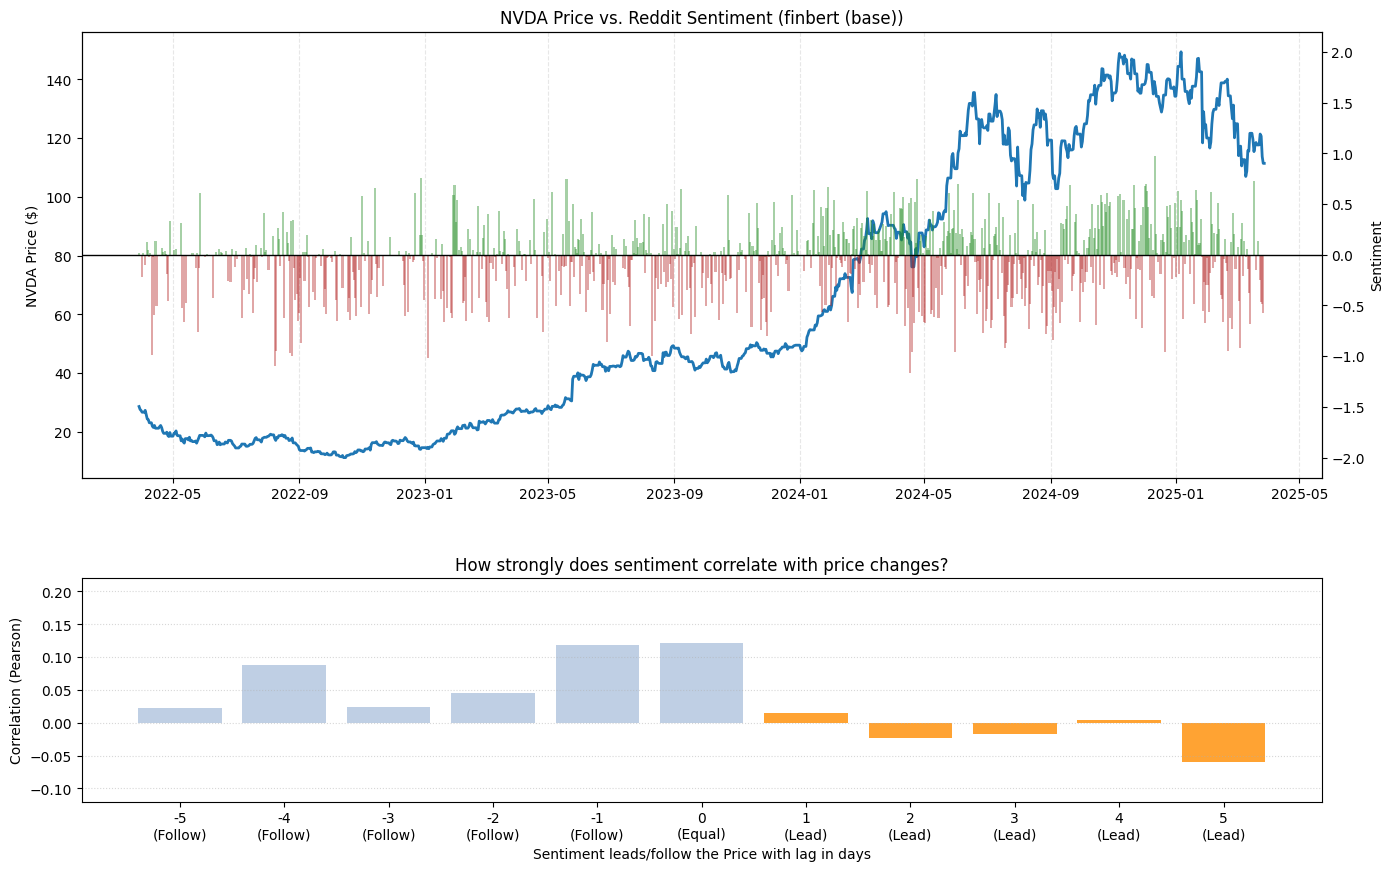

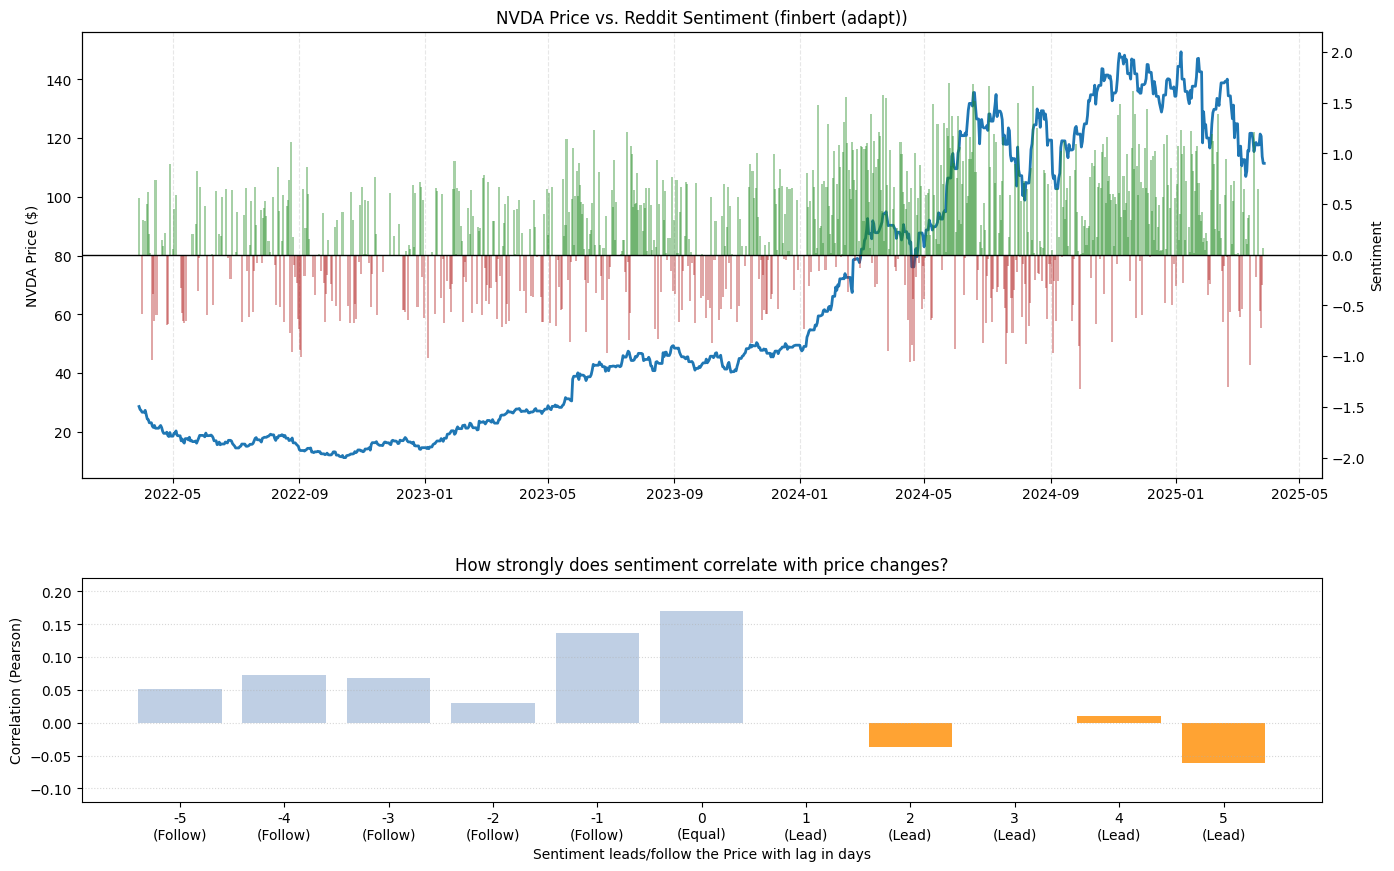

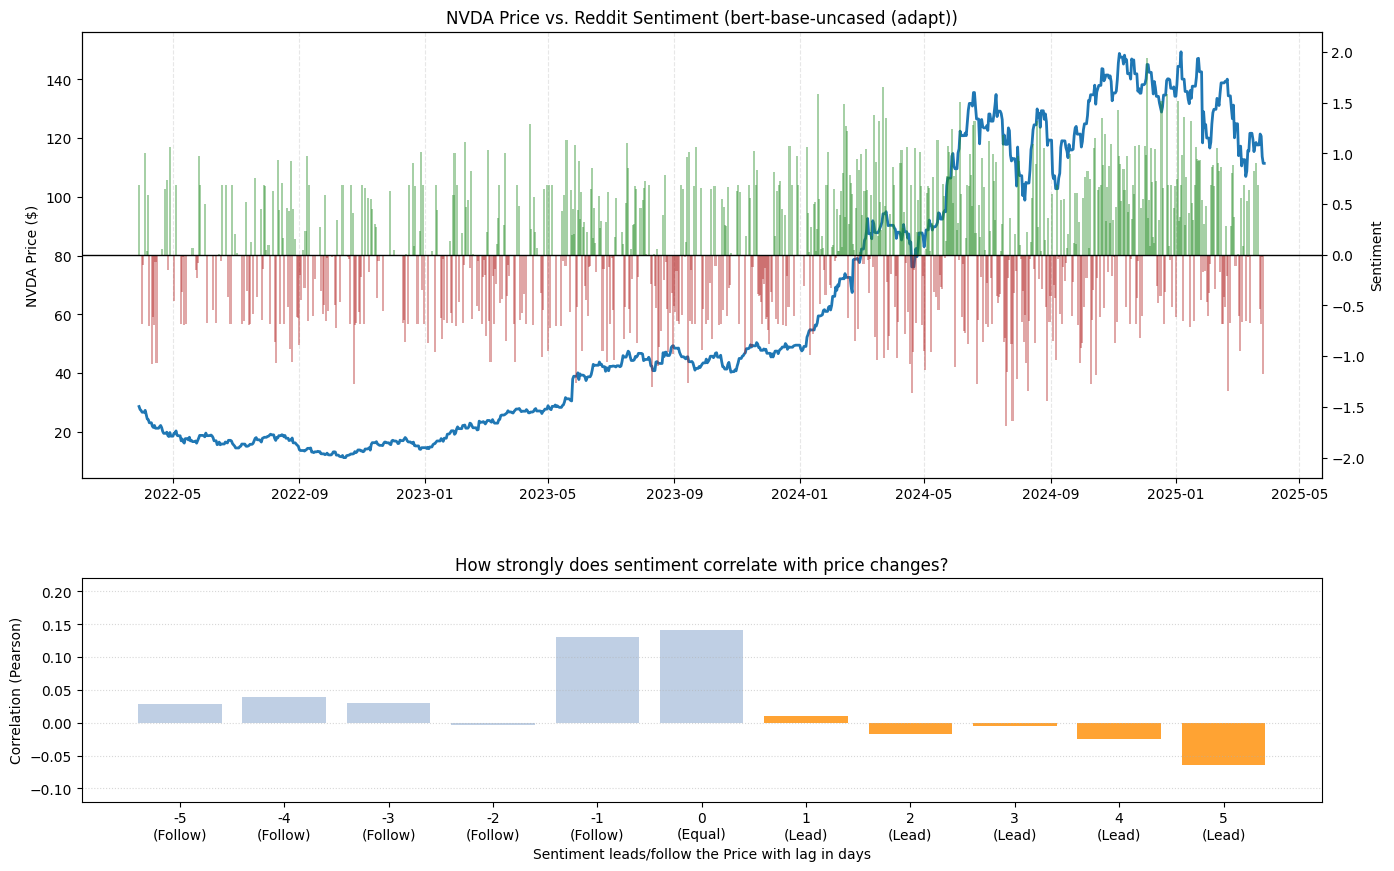

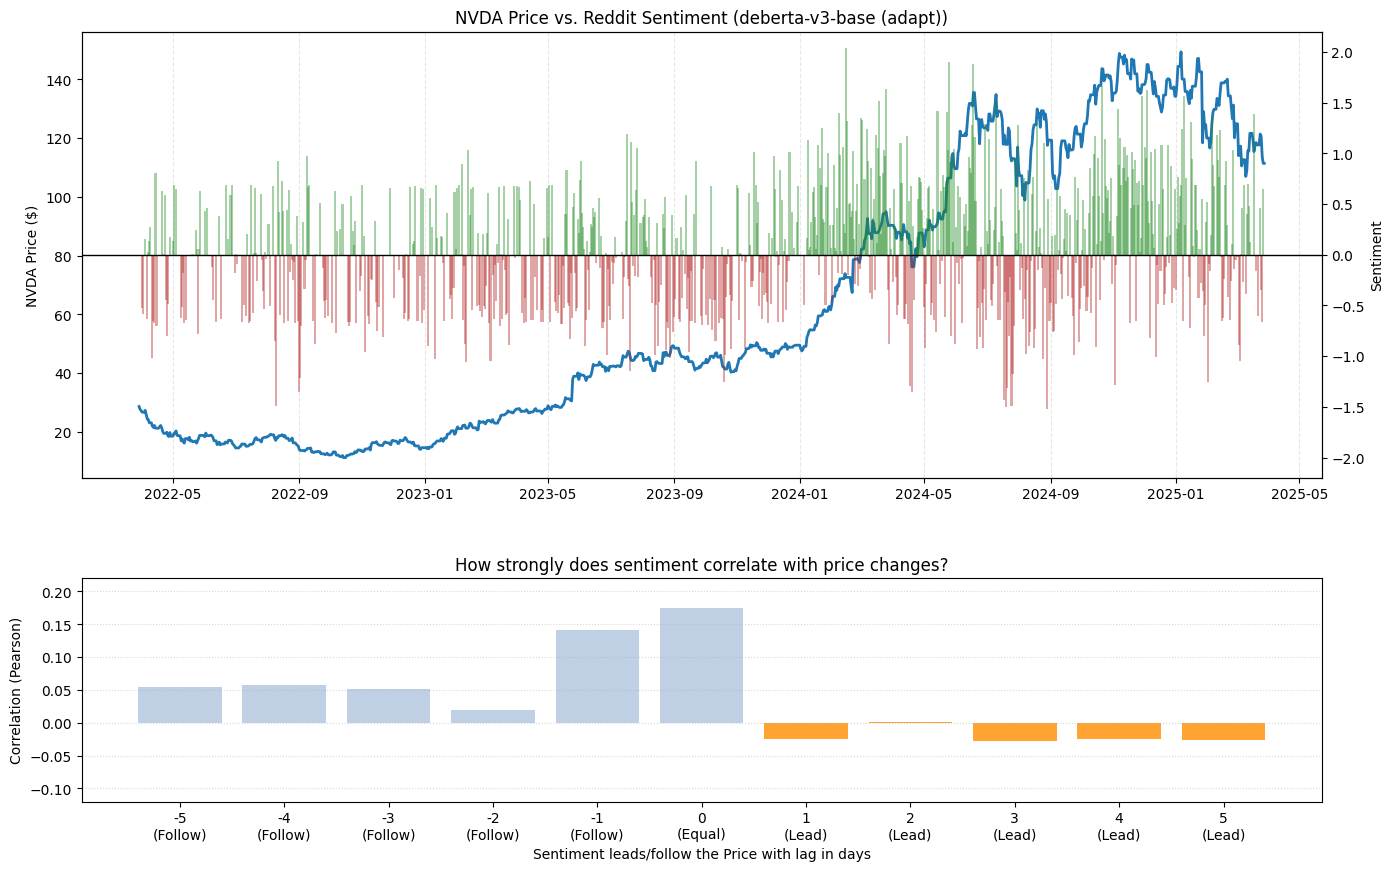

In [24]:
# Visualization Overview

for model_label, df_analysis in analysis_per_model.items():

    # Correlation over lags (-5 to +5 days)
    lags = range(-5, 6)
    correlations = [df_analysis["return"].corr(df_analysis["sentiment"].shift(lag)) for lag in lags]

    # Plotting Setup
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

    # UPPER CHART: Price vs. Sentiment
    ax_price = fig.add_subplot(gs[0])
    ax_sent = ax_price.twinx()

    # Price
    ax_price.plot(df_analysis.index, df_analysis["price"], color="#1f77b4", lw=2)
    ax_price.set_ylabel("NVDA Price ($)")
    ax_price.grid(True, axis="x", linestyle="--", alpha=0.3)
    ax_price.set_title(f"NVDA Price vs. Reddit Sentiment ({model_label})")

    # Sentiment
    colors = ["forestgreen" if x > 0 else "firebrick" for x in df_analysis["sentiment"]]
    ax_sent.bar(df_analysis.index, df_analysis["sentiment"], color=colors, alpha=0.4, width=2)
    ax_sent.set_ylabel("Sentiment")
    ax_sent.set_ylim(-2.2, 2.2)
    ax_sent.axhline(0, color="black", lw=1)

    # LOWER CHART: Correlation
    ax_corr = fig.add_subplot(gs[1])
    corr_colors = ["lightsteelblue" if x < 1 else "darkorange" for x in lags]

    ax_corr.bar(lags, correlations, color=corr_colors, alpha=0.8)
    ax_corr.set_title("How strongly does sentiment correlate with price changes?")
    ax_corr.set_ylabel("Correlation (Pearson)")
    ax_corr.set_ylim(-0.12, 0.22)
    ax_corr.set_xlabel("Sentiment leads/follow the Price with lag in days")
    ax_corr.set_xticks(lags)
    ax_corr.set_xticklabels([f"{l}\n(Lead)" if l > 0 else f"{l}\n(Follow)" if l < 0 else "0\n(Equal)" for l in lags])
    ax_corr.grid(axis="y", linestyle=":", alpha=0.5)

    plt.show()

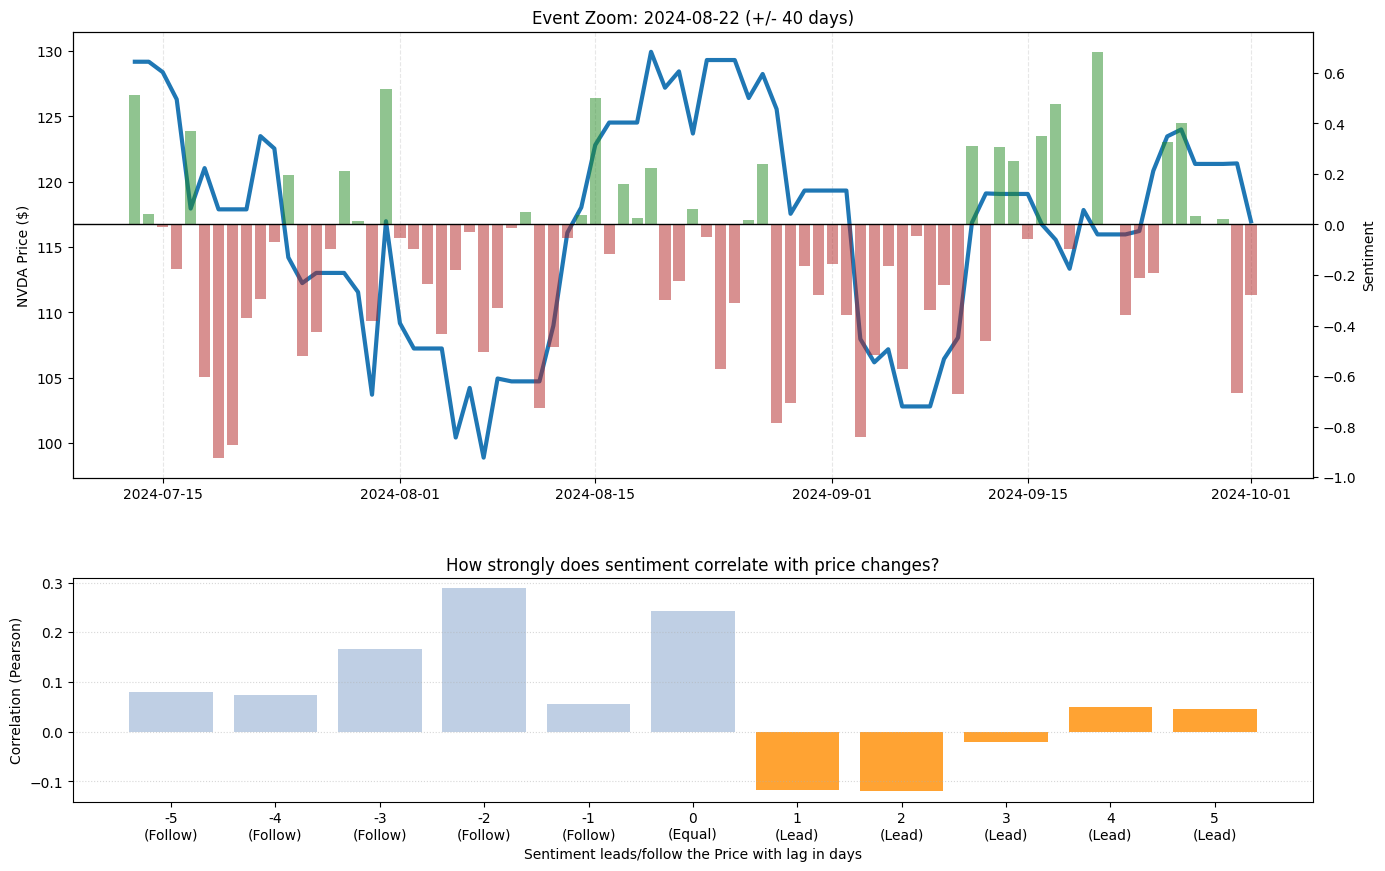

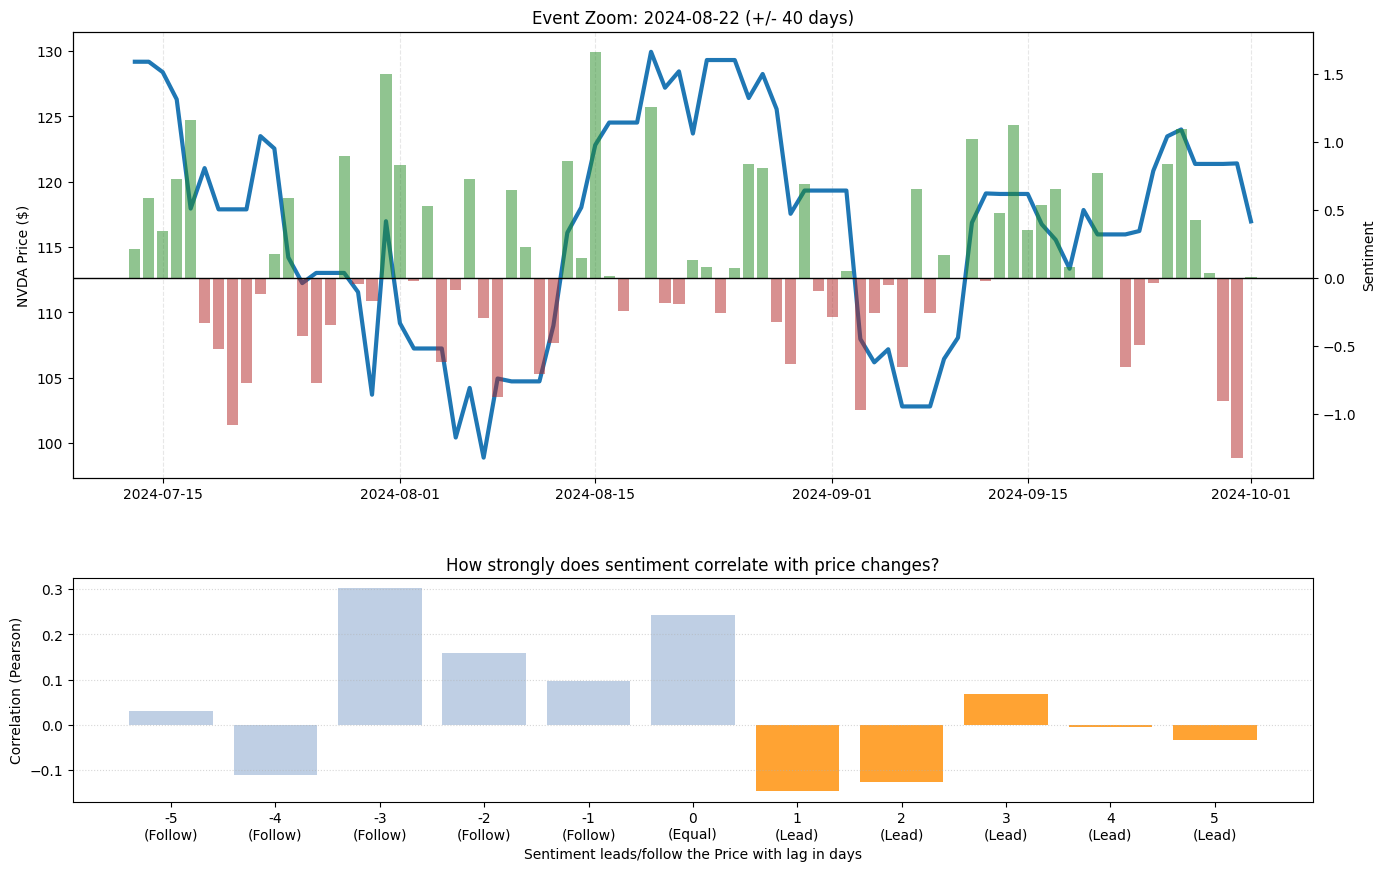

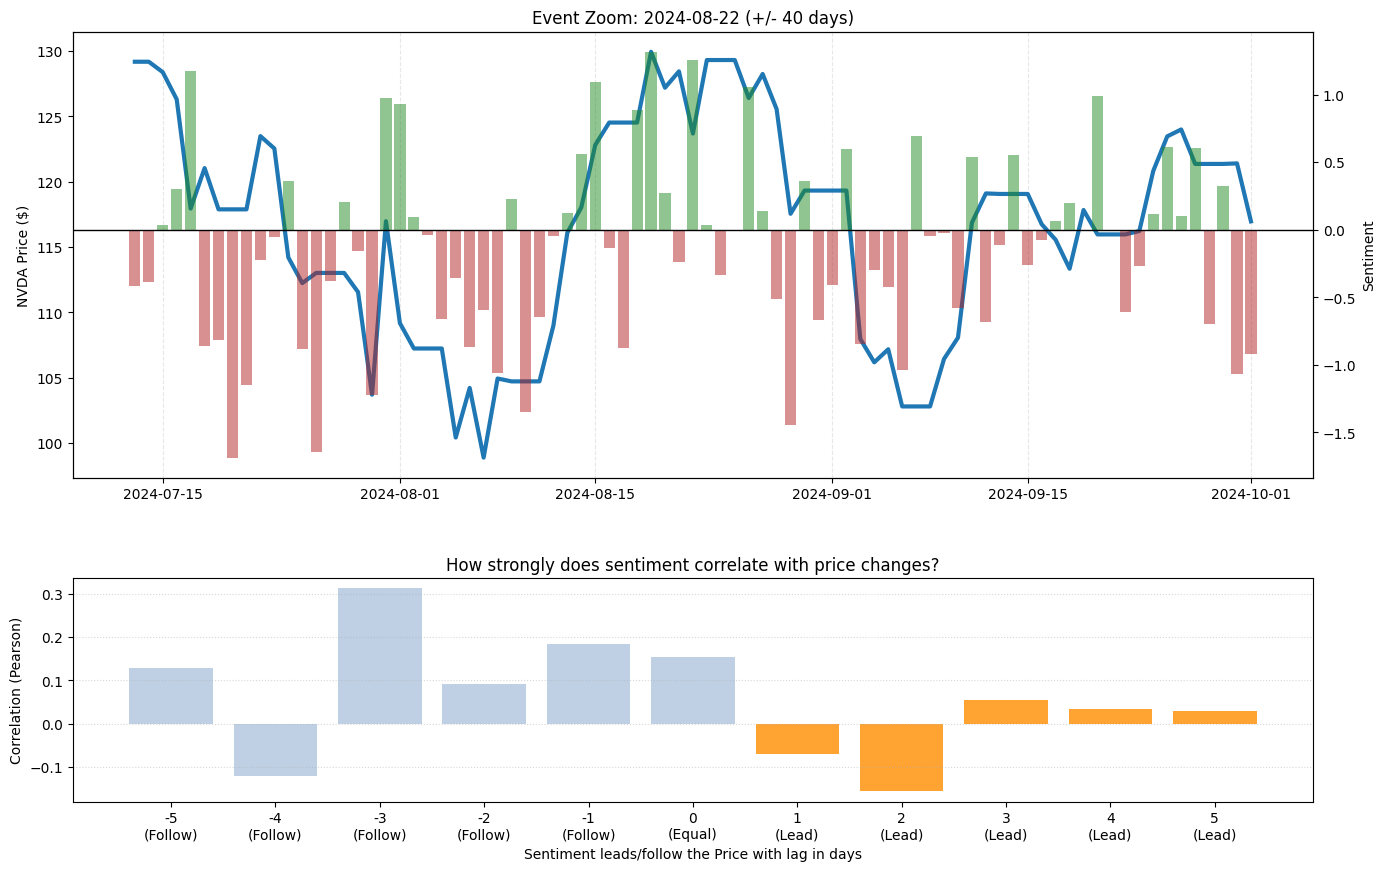

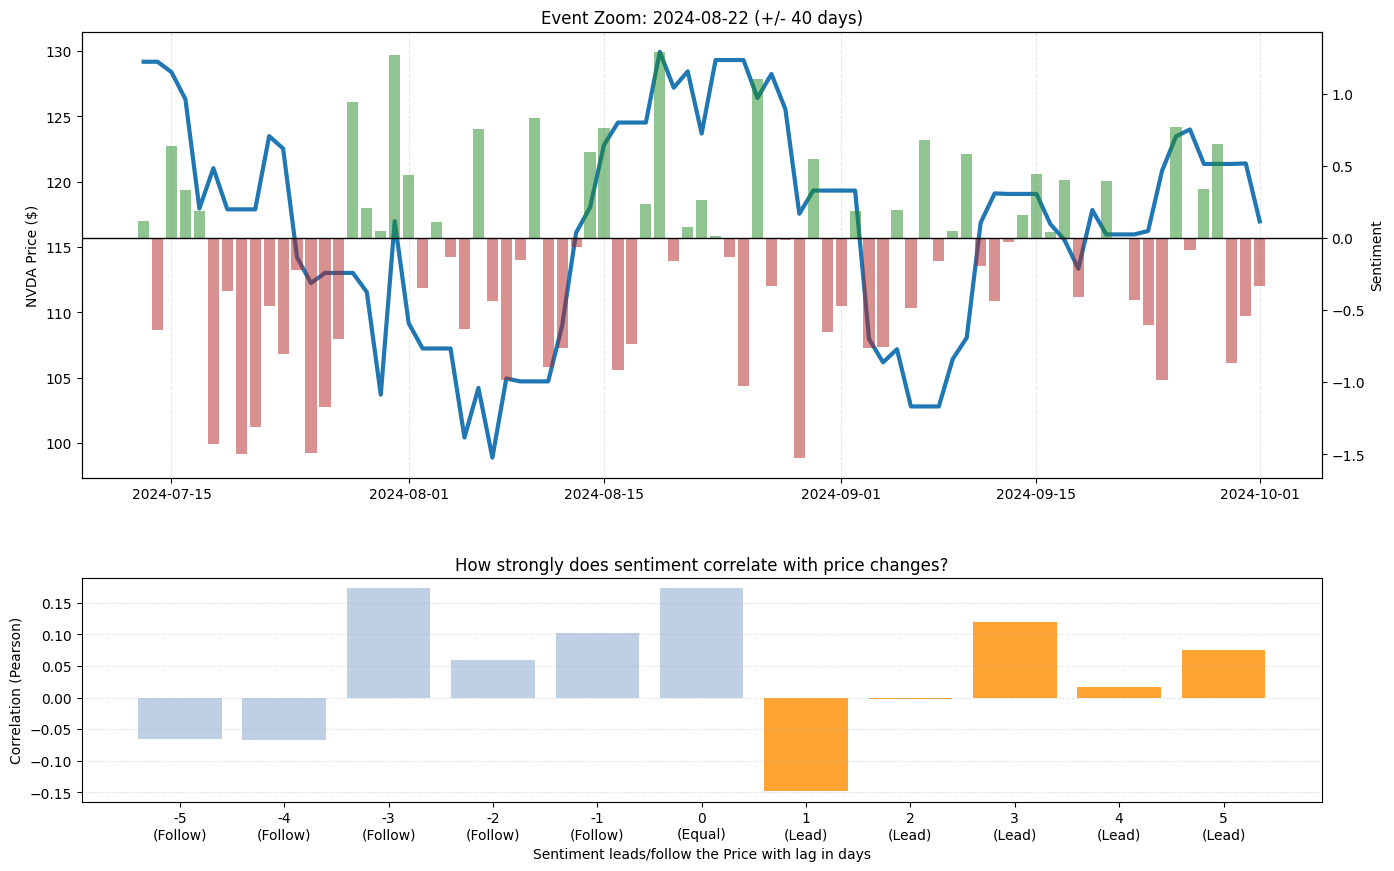

In [25]:
# Visualization Event Zoom

# Configuration Event, Filter time period
event_date = pd.to_datetime("2024-08-22").date()
zoom_days = 40
start = event_date - pd.Timedelta(days=zoom_days)
end = event_date + pd.Timedelta(days=zoom_days)

for model_label, df_analysis in analysis_per_model.items():

    df_zoom = df_analysis.loc[start:end]

    # Correlation over lags (-5 to +5 days)
    lags = range(-5, 6)
    local_correlations = [df_zoom["return"].corr(df_zoom["sentiment"].shift(lag)) for lag in lags]

    # Plotting Setup
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

    # UPPER CHART: Price vs. Sentiment
    ax_price = fig.add_subplot(gs[0])
    ax_sent = ax_price.twinx()

    # Price
    ax_price.plot(df_zoom.index, df_zoom["price"], color="#1f77b4", lw=3)
    ax_price.set_ylabel("NVDA Price ($)")
    ax_price.grid(True, axis="x", linestyle="--", alpha=0.3)
    ax_price.set_title(f"Event Zoom: {event_date} (+/- {zoom_days} days)")

    # Sentiment
    colors = ["forestgreen" if x > 0 else "firebrick" for x in df_zoom["sentiment"]]
    ax_sent.bar(df_zoom.index, df_zoom["sentiment"], color=colors, alpha=0.5, width=0.8)
    ax_sent.set_ylabel("Sentiment")
    ax_sent.axhline(0, color="black", lw=1)

    # LOWER CHART: Correlation
    ax_corr = fig.add_subplot(gs[1])
    corr_colors = ["lightsteelblue" if x < 1 else "darkorange" for x in lags]

    ax_corr.bar(lags, local_correlations, color=corr_colors, alpha=0.8)
    ax_corr.set_title("How strongly does sentiment correlate with price changes?")
    ax_corr.set_ylabel("Correlation (Pearson)")
    ax_corr.set_xlabel("Sentiment leads/follow the Price with lag in days")
    ax_corr.set_xticks(lags)
    ax_corr.set_xticklabels([f"{l}\n(Lead)" if l > 0 else f"{l}\n(Follow)" if l < 0 else "0\n(Equal)" for l in lags])
    ax_corr.grid(axis="y", linestyle=":", alpha=0.5)

    plt.show()